Loading libraries

In [ ]:
pip install causalgraphicalmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached causalgraphicalmodels-0.0.4-py3-none-any.whl (11 kB)


In [ ]:
!pip install ipython-autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from causalgraphicalmodels import StructuralCausalModel
from causalgraphicalmodels.csm import discrete_model, linear_model

import networkx as nx
import itertools

Functions for independence testing

In [ ]:
def is_indep(arr_1, arr_2, threshold=0.01, verbose=False):
    diff = arr_1.mean() * arr_2.mean() - (arr_1 * arr_2).mean()
    if verbose:
        print(diff)
    return abs(diff) < threshold

def is_cond_independent(data_df, var_1, var_2, cond_set):
    # create a copy with different combinations of values in cond_set
    data_df_tmp = data_df.copy()
    tmp_arr = data_df_tmp[cond_set[0]].astype(str).values
    for el in cond_set[1:]:
        tmp_arr += ' ' + data_df_tmp[el].astype(str)
    data_df_tmp['cond'] = tmp_arr

    # get unique combinations of values in cond_set
    cond_vals = data_df_tmp['cond'].unique()

    # for every possible combination check if we have independence
    for cond_val in cond_vals:
        tmp_df = data_df_tmp[data_df_tmp['cond'] == cond_vals[0]]
        if not is_indep(tmp_df[var_1].values, tmp_df[var_2].values):
            return False
    return True

# Generating data

For data generation we will be using python package [`causalgraphicalmodels`](https://github.com/ijmbarr/causalgraphicalmodels)

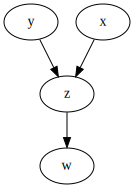

In [ ]:
fd0 = StructuralCausalModel({
    "x": lambda n_samples: np.random.binomial(n=1, p=0.5, size=n_samples),
    "y": lambda n_samples: np.random.binomial(n=1, p=0.5, size=n_samples),
    "z": discrete_model(["x", "y"], {
        (0,0): (0.1,0.9,), 
        (0,1): (0.3,0.7,),
        (1,0): (0.8,0.2,),
        (1,1): (0.9,0.1,),
        }),
    "w": discrete_model(["z"],{
        (0,): (0.8,0.2,),
        (1,): (0.1,0.9,), 
    })
})

fd0.cgm.draw()

Now we can sample data from the generated model

In [ ]:
n_samples=1000000
# n_samples=1000
data_df = fd0.sample(n_samples=n_samples)

# Step 1. Fully connected graph

In [ ]:
all_nodes = ['x', 'y', 'z', 'w']
nodes_pos = {'x': (1, 5), 'y': (5, 5), 'z': (1, 1), 'w': (5, 1)}

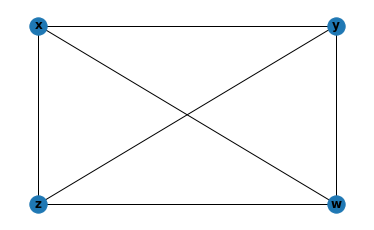

In [ ]:
G = nx.Graph()
G.add_nodes_from(all_nodes)
#G.add_nodes_from(tuple(zip(all_nodes, nodes_pos)))

for i in range(0, len(all_nodes)):
    node_1 = all_nodes[i]
    for j in range(i+1, len(all_nodes)):
        node_2 = all_nodes[j]
        G.add_edge(node_1, node_2)

plt.figure(figsize=(5, 3))
nx.draw(G, pos=nodes_pos, with_labels=True, font_weight='bold')

# Step 2. Test unconditional independence

In [ ]:
for i in range(0, len(all_nodes)):
    var_1 = all_nodes[i]
    for j in range(i + 1, len(all_nodes)):
        var_2 = all_nodes[j]
        # testStat, thresh = hsic_gam(data_df[var_1].values.reshape(-1, 1), data_df[var_2].values.reshape(-1, 1), alph=alph)
        # print(testStat, thresh)
        print("{} and {} are independent: {}".format(var_1, var_2, 
                                                     is_indep(data_df[var_1].values, data_df[var_2].values)))

x and y are independent: True
x and z are independent: False
x and w are independent: False
y and z are independent: False
y and w are independent: False
z and w are independent: False


Removing edge between $X$ and $Y$

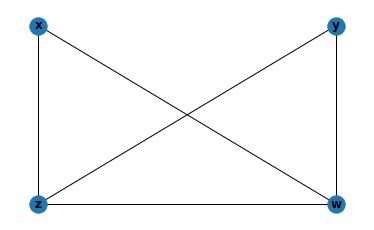

In [ ]:
G.remove_edge('x', 'y')
plt.figure(figsize=(5, 3))
nx.draw(G, pos=nodes_pos, with_labels=True, font_weight='bold')

# Step 3. Condition on 1 variable
For each pair of variables ($A$, $B$) having an edge between them, and for each variable $C$ with an edge connected to either of them, eliminate the edge between $A$ and $B$ if $\left(A ⊥⊥ B\right) | C$ 

In [ ]:
combinations = [
                ('x', 'z', 'w'), ('x', 'z', 'y'), 
                ('y', 'w', 'z'), ('y', 'w', 'x'),
                ('z', 'w', 'x'), ('z', 'w', 'y'),
                ('x', 'w', 'z'), ('x', 'w', 'y'),
                ('y', 'z', 'x'), ('y', 'z', 'w'),
                ]

In [ ]:
for var_1, var_2, cond_var in combinations:
    print('{} and {} are independent given {} = {}'.format(
        var_1, var_2, cond_var, is_cond_independent(data_df, var_1, var_2, [cond_var])
    ))

x and z are independent given w = False
x and z are independent given y = False
y and w are independent given z = True
y and w are independent given x = False
z and w are independent given x = False
z and w are independent given y = False
x and w are independent given z = True
x and w are independent given y = False
y and z are independent given x = False
y and z are independent given w = False


Removing edges between $Y$ and $W$ and between $X$ and $W$

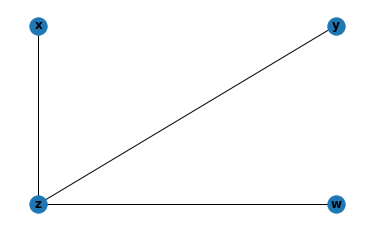

In [ ]:
G.remove_edge('y', 'w')
G.remove_edge('x', 'w')
plt.figure(figsize=(5, 3))
nx.draw(G, pos=nodes_pos, with_labels=True, font_weight='bold')

# Step 4. ...

# Step 5. Search for v-structure

Consider 3 cases:
1. $W - Z - Y$
2. $W - Z - X$
3. $X - Z - Y$

3-d case can be oriented as $X -> Z <- Y$

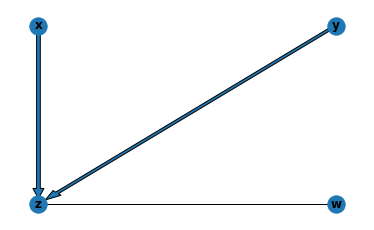

In [ ]:
plt.figure(figsize=(5, 3))
nx.draw(G, pos=nodes_pos, with_labels=True, font_weight='bold')

plt.arrow(1, 5, 0, -3.65, width=0.05)       # X - > Z
plt.arrow(5, 5, -3.75, -3.75, width=0.05)   # Y - > Z

# Step 6. Orientation propagation

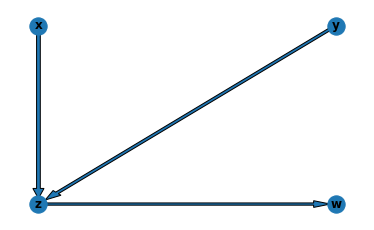

In [ ]:
plt.figure(figsize=(5, 3))
nx.draw(G, pos=nodes_pos, with_labels=True, font_weight='bold')

plt.arrow(1, 5, 0, -3.65, width=0.05)       # X - > Z
plt.arrow(5, 5, -3.75, -3.75, width=0.05)   # Y - > Z
plt.arrow(1, 1, 3.7, 0, width=0.05)   # Z - > W

# Excercise 1:

Simulate PC algorithm for the following graph (as in the example above)

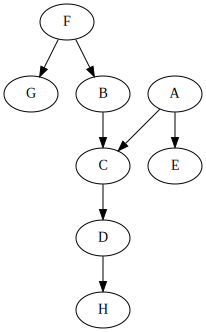

In [ ]:
fd0 = StructuralCausalModel({
    "A": lambda n_samples: np.random.binomial(n=1, p=0.5, size=n_samples),
    "F": lambda n_samples: np.random.binomial(n=1, p=0.4, size=n_samples),
    "E": discrete_model(["A"],{
        (0,): (0.6,0.4,),
        (1,): (0.1,0.9,), 
    }),
    "G": discrete_model(["F"],{
        (0,): (0.1,0.9,),
        (1,): (0.8,0.2,), 
    }),
    "B": discrete_model(["F"],{
        (0,): (0.3,0.7,),
        (1,): (0.6,0.4,), 
    }),
    "C": discrete_model(["A", "B"], {
        (0,0): (0.1,0.9,), 
        (0,1): (0.3,0.7,),
        (1,0): (0.8,0.2,),
        (1,1): (0.4,0.6,),
        }),
    "D": discrete_model(["C"],{
        (0,): (0.1,0.9,),
        (1,): (0.9,0.1,), 
    }),
    "H": discrete_model(["D"],{
        (0,): (0.6,0.4,), 
        (1,): (0.9,0.1,),
    })
})

fd0.cgm.draw()

In [ ]:
n_samples=1000000
# n_samples=1000
data_df = fd0.sample(n_samples=n_samples)

## Step 1. Fully connected graph

In [ ]:
all_nodes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
nodes_pos = {'A': (2,4), 'B': (4.5,4), 'C': (3,3.5), 'D': (2.5,2), 'E': (1,3), 
             'F': (5,5), 'G': (6,4), 'H': (3,1)}

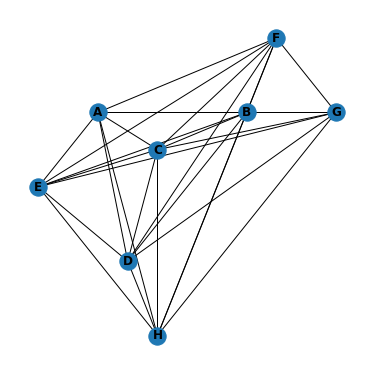

In [ ]:
G = nx.Graph()
G.add_nodes_from(all_nodes)
#G.add_nodes_from(tuple(zip(all_nodes, nodes_pos)))

for i in range(0, len(all_nodes)):
    node_1 = all_nodes[i]
    for j in range(i+1, len(all_nodes)):
        node_2 = all_nodes[j]
        G.add_edge(node_1, node_2)

plt.figure(figsize=(5, 5))
nx.draw(G, 
        pos=nodes_pos, 
        with_labels=True, font_weight='bold')

## Step 2. Test unconditional independence

In [ ]:
for i in range(0, len(all_nodes)):
    var_1 = all_nodes[i]
    for j in range(i + 1, len(all_nodes)):
        var_2 = all_nodes[j]
        # testStat, thresh = hsic_gam(data_df[var_1].values.reshape(-1, 1), data_df[var_2].values.reshape(-1, 1), alph=alph)
        # print(testStat, thresh)
        print("{} and {} are independent: {}".format(var_1, var_2, 
                                                     is_indep(data_df[var_1].values, data_df[var_2].values)))

A and B are independent: True
A and C are independent: False
A and D are independent: False
A and E are independent: False
A and F are independent: True
A and G are independent: True
A and H are independent: False
B and C are independent: False
B and D are independent: False
B and E are independent: True
B and F are independent: False
B and G are independent: False
B and H are independent: True
C and D are independent: False
C and E are independent: False
C and F are independent: True
C and G are independent: True
C and H are independent: False
D and E are independent: False
D and F are independent: True
D and G are independent: True
D and H are independent: False
E and F are independent: True
E and G are independent: True
E and H are independent: False
F and G are independent: False
F and H are independent: True
G and H are independent: True


Store independent variables

In [ ]:
indep_vars = []
for i in range(0, len(all_nodes)):
    var_1 = all_nodes[i]
    for j in range(i + 1, len(all_nodes)):
        var_2 = all_nodes[j]
        # testStat, thresh = hsic_gam(data_df[var_1].values.reshape(-1, 1), data_df[var_2].values.reshape(-1, 1), alph=alph)
        # print(testStat, thresh)
        if is_indep(data_df[var_1].values, data_df[var_2].values) == True:
          indep_vars.append((var_1, var_2))

In [ ]:
indep_vars = set(indep_vars)



```
indep_vars = [('A', 'B'),
 ('A', 'F'),
 ('A', 'G'),
 ('B', 'E'),
 ('B', 'H'),
 ('C', 'F'),
 ('C', 'G'),
 ('D', 'F'),
 ('D', 'G'),
 ('E', 'F'),
 ('E', 'G'),
 ('F', 'H'),
 ('G', 'H')]
```



Remove them from the graph

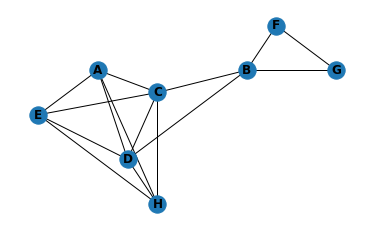

In [ ]:
for pair in indep_vars:
  G.remove_edge(pair[0], pair[1])
plt.figure(figsize=(5, 3))
nx.draw(G, pos=nodes_pos, with_labels=True, font_weight='bold')

## Step 3. Condition on 1 variable
For each pair of variables ($A$, $B$) having an edge between them, and for each variable $C$ with an edge connected to either of them, eliminate the edge between $A$ and $B$ if $\left(A ⊥⊥ B\right) | C$ 

In [ ]:
all_nodes

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

In [ ]:
# list all possible tuples with no repetition
N = 3
tuples = list(itertools.product(all_nodes, repeat = 3 ))
tuples
tuples_unique = []
for tup in tuples:
  if len(set(tup)) == 3:
    tuples_unique.append(tup)

In [ ]:
combinations = [
                ('E', 'A', 'D'), ('E', 'A', 'H'), ('E', 'A', 'C'),  
                ('E', 'D', 'A'), ('E', 'D', 'C'), ('E', 'D', 'H'), ('E', 'D', 'B'), 
                ('E', 'H', 'A'), ('E', 'H', 'C'), ('E', 'H', 'D'),
                ('E', 'C', 'A'), ('E', 'C', 'D'), ('E', 'C', 'H'), ('E', 'C', 'B'),
                ('A', 'C', 'E'), ('A', 'C', 'D'), ('A', 'C', 'H'), ('A', 'C', 'B'),
                ('A', 'D', 'E'), ('A', 'D', 'H'), ('A', 'D', 'B'), ('A', 'D', 'C'),
                ('A', 'H', 'E'), ('A', 'H', 'C'), ('A', 'H', 'D'), 
                ('H', 'D', 'E'), ('H', 'D', 'A'), ('H', 'D', 'B'), ('H', 'D', 'C'),
                ('H', 'C', 'E'), ('H', 'C', 'D'), ('H', 'C', 'A'), ('H', 'C', 'B'),
                ('D', 'C', 'E'), ('D', 'C', 'A'), ('D', 'C', 'B'), ('D', 'C', 'H'),
                ('D', 'B', 'E'), ('D', 'B', 'A'), ('D', 'B', 'C'), ('D', 'B', 'H'), ('D', 'B', 'F'), ('D', 'B', 'G'),
                ('B', 'C', 'E'), ('B', 'C', 'A'), ('B', 'C', 'D'), ('B', 'C', 'H'), ('B', 'C', 'F'), ('B', 'C', 'G'),
                ('B', 'F', 'C'), ('B', 'F', 'D'), ('B', 'F', 'G'),
                ('B', 'G', 'F'), ('B', 'G', 'C'), ('B', 'G', 'D'),
                ('F', 'G', 'B') 
                ]

In [ ]:
for var_1, var_2, cond_var in combinations:
    print('{} and {} are independent given {} = {}'.format(
        var_1, var_2, cond_var, is_cond_independent(data_df, var_1, var_2, [cond_var])
    ))

E and A are independent given D = False
E and A are independent given H = False
E and A are independent given C = False
E and D are independent given A = True
E and D are independent given C = True
E and D are independent given H = False
E and D are independent given B = False
E and H are independent given A = True
E and H are independent given C = True
E and H are independent given D = True
E and C are independent given A = True
E and C are independent given D = False
E and C are independent given H = False
E and C are independent given B = False
A and C are independent given E = False
A and C are independent given D = False
A and C are independent given H = False
A and C are independent given B = False
A and D are independent given E = False
A and D are independent given H = False
A and D are independent given B = False
A and D are independent given C = True
A and H are independent given E = False
A and H are independent given C = True
A and H are independent given D = True
H and D a

In [ ]:
indep_vars_cond_1 = []
for var_1, var_2, cond_var in combinations:
    if is_cond_independent(data_df, var_1, var_2, [cond_var]) == True:
      indep_vars_cond_1.append((var_1, var_2))

In [ ]:
indep_vars_cond_1 = list(set(indep_vars_cond_1))

In [ ]:
indep_vars_cond_1 = list(set(indep_vars_cond_1) - set(indep_vars))

In [ ]:
indep_vars_cond_1

[('E', 'C'),
 ('E', 'D'),
 ('A', 'H'),
 ('E', 'H'),
 ('B', 'G'),
 ('A', 'D'),
 ('D', 'B'),
 ('H', 'C')]



```
indep_vars_cond_1 = [('E', 'H'),
 ('D', 'B'),
 ('B', 'G'),
 ('E', 'D'),
 ('A', 'D'),
 ('B', 'C'),
 ('H', 'C'),
 ('A', 'H'),
 ('E', 'C')]
```



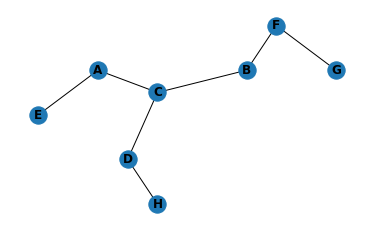

In [ ]:
for pair in indep_vars_cond_1:
  G.remove_edge(pair[0], pair[1])
plt.figure(figsize=(5, 3))
nx.draw(G, pos=nodes_pos, with_labels=True, font_weight='bold')

## Step 4. Condition on 2 variables or more

The following function creates all possible sublists (with lengths more or equal to two) for a given list

In [ ]:
def sub_lists(my_list):
  subs = []
  for i in range(0, len(my_list)+3):
    temp = [list(x) for x in itertools.combinations(my_list, i) if len(x) > 1]
    if len(temp) > 1:
      subs.extend(temp)
  subs.extend([list(my_list)])   
  return subs

In [ ]:
L = ['A', 'B', 'C']

In [ ]:
sub_lists(['A','B','C'])

[['A', 'B'], ['A', 'C'], ['B', 'C'], ['A', 'B', 'C']]

In [ ]:
list(itertools.combinations(L, 3))

[('A', 'B', 'C')]

In [ ]:
sub_lists(['A','B','C'])

[['A', 'B'], ['A', 'C'], ['B', 'C'], ['A', 'B', 'C']]

I create a dictionary with keys as the two edges that are connected and values as a list of edges connecting to either of them.

In [ ]:
conds = dict()
for tup in combinations:
  for tup2 in combinations:
    if (tup[0] == tup2[0]) & (tup[1] == tup2[1]):
      conds[(tup[0], tup[1])] = []
for tup in combinations:
  for tup2 in combinations:
    if (tup[0] == tup2[0]) & (tup[1] == tup2[1]):
      conds[(tup[0], tup[1])].append(tup[2])
      conds[(tup[0], tup[1])].append(tup2[2])      

In [ ]:
for pair in conds:
  conds[pair] = set(conds[pair])


Now I create another dictionary which has the same keys as before but with values as all possible 2 or more sets of variables as condition set.

In [ ]:
conds_dict = conds.copy()
for pair in conds_dict:
  conds_dict[pair] = sub_lists(conds_dict[pair])


In [ ]:
conds[('B', 'G')]

{'C', 'D', 'F'}

In [ ]:
sub_lists(conds[('B', 'G')])

[['D', 'C'], ['D', 'F'], ['C', 'F'], ['D', 'C', 'F']]

In [ ]:
 conds

{('E', 'A'): {'C', 'D', 'H'},
 ('E', 'D'): {'A', 'B', 'C', 'H'},
 ('E', 'H'): {'A', 'C', 'D'},
 ('E', 'C'): {'A', 'B', 'D', 'H'},
 ('A', 'C'): {'B', 'D', 'E', 'H'},
 ('A', 'D'): {'B', 'C', 'E', 'H'},
 ('A', 'H'): {'C', 'D', 'E'},
 ('H', 'D'): {'A', 'B', 'C', 'E'},
 ('H', 'C'): {'A', 'B', 'D', 'E'},
 ('D', 'C'): {'A', 'B', 'E', 'H'},
 ('D', 'B'): {'A', 'C', 'E', 'F', 'G', 'H'},
 ('B', 'C'): {'A', 'D', 'E', 'F', 'G', 'H'},
 ('B', 'F'): {'C', 'D', 'G'},
 ('B', 'G'): {'C', 'D', 'F'},
 ('F', 'G'): {'B'}}

In [ ]:
conds_dict

{('E', 'A'): [['C', 'H'], ['C', 'D'], ['H', 'D'], ['C', 'H', 'D']],
 ('E', 'D'): [['H', 'C'],
  ['H', 'B'],
  ['H', 'A'],
  ['C', 'B'],
  ['C', 'A'],
  ['B', 'A'],
  ['H', 'C', 'B'],
  ['H', 'C', 'A'],
  ['H', 'B', 'A'],
  ['C', 'B', 'A'],
  ['H', 'C', 'B', 'A']],
 ('E', 'H'): [['C', 'A'], ['C', 'D'], ['A', 'D'], ['C', 'A', 'D']],
 ('E', 'C'): [['H', 'B'],
  ['H', 'A'],
  ['H', 'D'],
  ['B', 'A'],
  ['B', 'D'],
  ['A', 'D'],
  ['H', 'B', 'A'],
  ['H', 'B', 'D'],
  ['H', 'A', 'D'],
  ['B', 'A', 'D'],
  ['H', 'B', 'A', 'D']],
 ('A', 'C'): [['D', 'H'],
  ['D', 'B'],
  ['D', 'E'],
  ['H', 'B'],
  ['H', 'E'],
  ['B', 'E'],
  ['D', 'H', 'B'],
  ['D', 'H', 'E'],
  ['D', 'B', 'E'],
  ['H', 'B', 'E'],
  ['D', 'H', 'B', 'E']],
 ('A', 'D'): [['C', 'H'],
  ['C', 'B'],
  ['C', 'E'],
  ['H', 'B'],
  ['H', 'E'],
  ['B', 'E'],
  ['C', 'H', 'B'],
  ['C', 'H', 'E'],
  ['C', 'B', 'E'],
  ['H', 'B', 'E'],
  ['C', 'H', 'B', 'E']],
 ('A', 'H'): [['D', 'C'], ['D', 'E'], ['C', 'E'], ['D', 'C', 'E']],
 ('H', '

In the code below, all connected edges' dependency are reported when conditioned on a condition set. 
The code took 40 minutes. So it wouldn't be useful on large graphs.

In [ ]:
%load_ext autotime

time: 487 µs (started: 2022-10-23 20:25:06 +00:00)


In [ ]:
for var_1, var_2, cond_var in combinations:
  for cond in conds_dict[var_1, var_2]:
    print('{} and {} are independent given {} = {}'.format(
        var_1, var_2, cond, is_cond_independent(data_df, var_1, var_2, cond)
    ))

E and A are independent given ['C', 'H'] = False
E and A are independent given ['C', 'D'] = False
E and A are independent given ['H', 'D'] = False
E and A are independent given ['C', 'H', 'D'] = False
E and A are independent given ['C', 'H'] = False
E and A are independent given ['C', 'D'] = False
E and A are independent given ['H', 'D'] = False
E and A are independent given ['C', 'H', 'D'] = False
E and A are independent given ['C', 'H'] = False
E and A are independent given ['C', 'D'] = False
E and A are independent given ['H', 'D'] = False
E and A are independent given ['C', 'H', 'D'] = False
E and D are independent given ['H', 'C'] = True
E and D are independent given ['H', 'B'] = False
E and D are independent given ['H', 'A'] = True
E and D are independent given ['C', 'B'] = True
E and D are independent given ['C', 'A'] = True
E and D are independent given ['B', 'A'] = True
E and D are independent given ['H', 'C', 'B'] = True
E and D are independent given ['H', 'C', 'A'] = True
E 

Now I store independent connected edges in order to remove them from graph.
So... another 40 minutes... :)

In [ ]:
indep_vars_cond = []
for var_1, var_2, cond_var in combinations:
  for cond in conds_dict[var_1, var_2]:
    if is_cond_independent(data_df, var_1, var_2, cond) == True:
      indep_vars_cond.append((var_1, var_2))

time: 37min 48s (started: 2022-10-23 21:03:46 +00:00)


In [ ]:
%unload_ext autotime

In [ ]:
indep_vars_cond = list(set(indep_vars_cond))

In [ ]:
indep_vars_cond

[('E', 'C'),
 ('E', 'D'),
 ('A', 'H'),
 ('E', 'H'),
 ('B', 'G'),
 ('A', 'D'),
 ('D', 'B'),
 ('H', 'C')]



```
indep_vars_cond = [('E', 'C'),
 ('E', 'D'),
 ('E', 'H'),
 ('D', 'B'),
 ('A', 'H'),
 ('B', 'G'),
 ('H', 'C'),
 ('A', 'D')]
```



In [ ]:
set(indep_vars_cond) == set(indep_vars_cond_1)

True

In [ ]:
list(set(indep_vars_cond) - set(indep_vars_cond_1) - set(indep_vars))

[]

I conclude that conditioning on one variable sufficed for our example, as conditioning on more variables didn't yield anymore pair of independent edges.

## Step 5. Search for v-structure

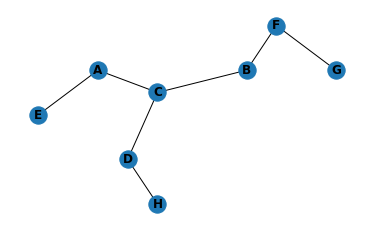

In [ ]:
plt.figure(figsize=(5, 3))
nx.draw(G, pos=nodes_pos, with_labels=True, font_weight='bold')

We consider the following cases:
1. $E - A - C$:

$A$ was conditioned on in eliminating the
$E-C$ edge, therefore we shouldn't have a inverted fork.

2. $C - D - H$

$D$ was conditioned on in eliminating the
$H-C$ edge, therefore we shouldn't have a inverted fork.


3. $A - C - D$

$C$ was conditioned on in eliminating the
$E-C$ edge, therefore we shouldn't have a inverted fork.


4. $B - F - G$

$C$ was conditioned on in eliminating the
$E-C$ edge, therefore we shouldn't have a inverted fork.


In [ ]:
G.edges

EdgeView([('A', 'C'), ('A', 'E'), ('B', 'C'), ('B', 'F'), ('C', 'D'), ('D', 'H'), ('F', 'G')])

In [ ]:
list(G.adjacency())

[('A', {'C': {}, 'E': {}}),
 ('B', {'C': {}, 'F': {}}),
 ('C', {'A': {}, 'B': {}, 'D': {}}),
 ('D', {'C': {}, 'H': {}}),
 ('E', {'A': {}}),
 ('F', {'B': {}, 'G': {}}),
 ('G', {'F': {}}),
 ('H', {'D': {}})]

No V-structure was found in the graph. 
And algorithm doesn't tell more about how to orient the edges.

Anyway, I depict some examples of variants of how we can orient the graph while satisfying no V-structure condition I set:

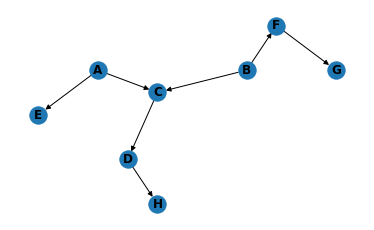

In [ ]:
DG = nx.DiGraph()
DG.add_nodes_from(G.nodes)
DG.add_edges_from(G.edges)

plt.figure(figsize=(5, 3))
nx.draw(DG, pos=nodes_pos, with_labels=True, font_weight='bold')

In this case we have a fork $E-A-C$ and a chain $A - C -D - H$.

Also we have the chain $B - F - G$.

In [ ]:
DG.edges

OutEdgeView([('A', 'C'), ('A', 'E'), ('B', 'C'), ('B', 'F'), ('C', 'D'), ('D', 'H'), ('F', 'G')])

Another example:


In [ ]:
DG.remove_edge('A', 'E')
DG.add_edge('E', 'A')

DG.remove_edge('B', 'F')
DG.add_edge('F', 'B')

DG.remove_edge('F', 'G')
DG.add_edge('G', 'F')


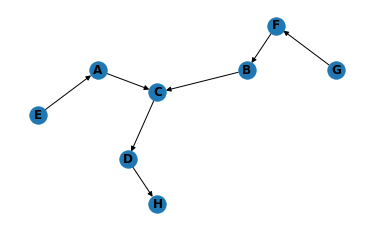

In [ ]:

plt.figure(figsize=(5, 3))
nx.draw(DG, pos=nodes_pos, with_labels=True, font_weight='bold')

In this case we have a chain $E - A - C - D -H$.
And also a chain $G - F -B$

If these examples have the same causal structure, then all can be accepted. 